

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>


## Sparse Random Projection

#### Abdulhamid Alsousy
#### PGE, University of Texas at Austin

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

Data in a lot of cases has high velocity and dimensionality, and typically dimensional reduction is conducted to optimize the size of the datasets. However, majority of classical dimensionality reduction methods, such as PCA and MDS, are computationally expensive for such scenarios. This is where random projection shines, as it utlizes the assumption of near orthoganality in high dimensional space, sacrificing some accuracy for processing speed. This is extremly valuable especially when dealing with high dimensionality and real-time data such as metadata.

### Import Packages

we will import the following packages for this workflow

In [19]:
from sklearn import random_projection          # import random projection functions
from sklearn.metrics import pairwise_distances # import pairwise distance metrics functions
from sklearn.metrics import r2_score           # import R2 metric 
import seaborn as sns                          # matrix scatter plots
import numpy as np                             # working with data and model arrays
import matplotlib.pyplot as plt                # for plotting 
from sklearn.datasets import load_digits       # digits dataset
import scipy.sparse as sparse                  # to generate random data for random projection
import sys
from time import time

### Functions

The following functions will be used in the workflow for plotting.

In [56]:
def plotter(data, error, required_dimensions):
    plt.subplot(1,2,1)
    plt.semilogy(error,required_dimensions); plt.title("min dimensions required vs acceptable error") 
    plt.xlabel("error (ε)");plt.ylabel("minimum dimensins required (m)")
    plt.grid(); plt.legend([f"n_samples = {n}" for n in data], loc="upper right")
    
    Tranposed_required_dimensions = required_dimensions.transpose()
    
    plt.subplot(1,2,2)
    plt.loglog(data,Tranposed_required_dimensions); plt.legend("")
    plt.title("min observations required vs min dimensions required for specific errors")
    plt.xlabel("number of observations (n)"); plt.ylabel("minimum dimensins required (m)"); plt.grid() 
    plt.legend([f"error = {eps:0.2}" for eps in error], loc="upper right")
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=0.8, wspace=0.2, hspace=0.2); plt.show()
    
def sens_plotter(n_comp, r, delta_t, size_, min_accepted_r):     
    plt.subplot(131)    
    plt.plot(n_comp, r); plt.title("R2 vs Dimensionality Reduction")
    plt.xlabel("Number of Dimensions"); plt.ylabel("R2"); plt.ylim(-1,1); plt.grid()

    if max(r) >= min_accepted_r:
        plt.axhline(r[min(np.where(r2 >= min_accepted_r)[0])], color= 'r')
        plt.axvline(n_comp[min(np.where(r2 >= min_accepted_r)[0])], color= 'r')
    
    plt.subplot(132)        
    plt.plot(n_comp, delta_t); plt.title("Time Required for Dimensionality Reduction")
    plt.xlabel("Number of Dimensions"); plt.ylabel("Time, s"); plt.grid()        
    
    if max(r) >= min_accepted_r:
        plt.axvline(n_comp[min(np.where(r2 >= min_accepted_r)[0])], color= 'r')
        plt.axhline(delta_t[min(np.where(r2 >= min_accepted_r)[0])], color= 'r')

    plt.subplot(133)    
    plt.plot(n_comp, size_); plt.title("Size vs Dimensionality Reduction")
    plt.xlabel("Number of Dimensions"); plt.ylabel("Size, MB"); plt.grid()
    
    if max(r) >= min_accepted_r:
        plt.axvline(n_comp[min(np.where(r2 >= min_accepted_r)[0])], color= 'r')
        plt.axhline(size_[min(np.where(r2 >= min_accepted_r)[0])], color= 'r')        

    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()  

def pairwise_plotter(proj_dist, dist, n_comp):
    plt.subplot(121)
    min_dist = min(proj_dist.min(), dist.min())
    max_dist = max(proj_dist.max(), dist.max())
    plt.hexbin(dist, proj_dist, gridsize=100, extent=[min_dist, max_dist, min_dist, max_dist], cmap='inferno')
    plt.axline([min_dist, min_dist], [max_dist, max_dist], color='white')

    plt.xlabel("Pairwise squared distances in original space");plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" % n_comp)

    cb = plt.colorbar(); cb.set_label("Sample pairs counts")
    ratio = proj_dist / dist
    print(f"Mean distances ratio: {np.mean(ratio):.2f} (STDEV {np.std(ratio):.2f})")

    plt.subplot(122)
    plt.hist(ratio, bins=50, edgecolor="k", density=True); plt.title("Histogram of pairwise distance ratio for n_components=%d" % n_comp)
    plt.xlabel("Squared distances ratio: projected / original"); plt.ylabel("Distribution of samples pairs")
    
    plt.axvline(np.mean(ratio)-np.std(ratio), color= 'r', linestyle='--')
    plt.axvline(np.mean(ratio), color= 'r')    
    plt.axvline(np.mean(ratio)+np.std(ratio), color= 'r', linestyle='--')
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.2); plt.show()
    
def data_plotter(case, data):
    if case != 1:
        #plt.subplot(121)
        plt.spy(data); plt.title(f"Randomly Generated Sparse Matrix ({data.shape[0]}x{data.shape[1]})")
        plt.ylabel("Data samples, n"); plt.xlabel("Features, m")
        dummy = sparse.random(100,300, density=0.01, random_state= 73073)
        plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.0, wspace=0.2, hspace=0.2)
    else:
        plt.spy(data)

### Load Data

For random projection we need big datasets. The block below loads a dataset from sciket learn called digits. Moreover, we load a function which enables us to generate a random sparse matrix. A sparse matrix is a matrix which consists mostly of zeros.

If you choose to generate a sparse matrix (option 2), the density term is used to control the sparsity of the matrix. The blue boxes shown in the sparse matirx generated, indicate the non zero elements. The reason sparse matrix is genereated as an input instead of a regular matrix, is to lower the computational complexity even further for random projection.

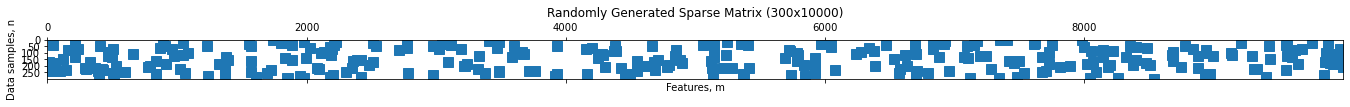

In [39]:
dataset   = 2
n         = 300
m         = 10_000
rand_seed = 73073

if dataset == 1:
    data = load_digits().data[:n]    # load scikit learn digits dataset
    
elif dataset == 2:
    data = sparse.random(n, m, density = 0.0001, random_state= rand_seed) # generate random dataset

data_plotter(dataset, data)

### 1. Random Projection

Random projections utilizes near orthoganality in high dimensional space for dimensionality reduction, hence avoiding the high complexity associated with such problems. According to Johnson-Lindenstrauss lemma, in order to project the data to a lower space with $m$ dimensions with a certain accuracy\error ($\epsilon$), the minimum required dimesnions needed depends on the number of sampels $n$: 

$$ m \ge \frac{ln(n)}{\epsilon^2}$$

The Johnson-Lindenstrauss lemma specifies the minimum dimensions of the lower-dimensional space so that the $\epsilon$-embedding is maintained by the equation below:
$$ (1- \epsilon) \left\lvert{x_1 - x_2}\right\rvert^2 \lt \left\lvert{x_1^{'} - x_2^{'}}\right\rvert^2 \lt (\epsilon+1)\left\lvert{x_1 - x_2}\right\rvert^2$$

For a pair of points $x_1,x_2$ and their projections $x_{1}^{'}$ , $x_{2}^{'}$, 

The following block illustrates the relationship between the number of dimensions, number of samples and error. the plots summarize the relationship as:

* Min $m$ required increase as $n$ increase for the same $\epsilon$
* Min $m$ required increase as $\epsilon$ decreases for the same $n$

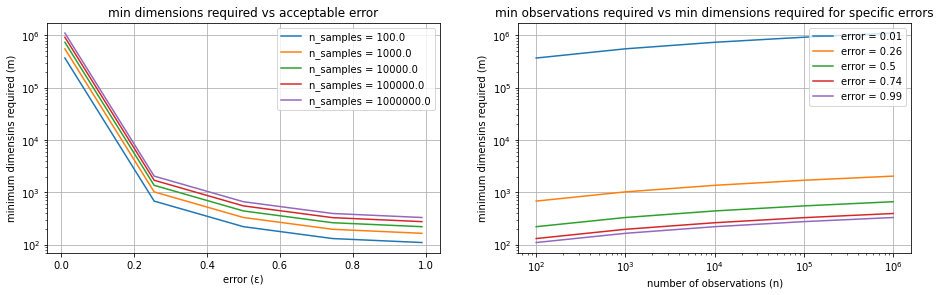

In [40]:
min_n_samples = 2
max_n_samples = 6
number_n_samples= 5

min_err = 0.01
max_err = 0.99
num_err= 5

error = np.linspace(min_err, max_err, num_err)
n = np.logspace(min_n_samples, max_n_samples, number_n_samples)#, dtype=int)

required_dimensions  = np.zeros((num_err, number_n_samples))
eps_values           = np.zeros((num_err, number_n_samples))

l=0
k=0

for sample in n:
    for err in error:
        required_dimensions[l, k] = random_projection.johnson_lindenstrauss_min_dim(n_samples=sample, eps=err)          
        l = l +1
    k = k+1
    l = 0
    
plotter(n, error, required_dimensions)

### 2. Sparse Random Projection

Random projection has multiple versions\approaches. In this workflow we will utilize sparse random projection, due to it being one of the least computational expensive to reduce the dimensionality and complexity of a dataset, however this comes with further sacrifice of accuracy.

$$ matrix_{nxm} = \begin{bmatrix} x_{11} & x_{12} & . & . & . &  x_{1m} 
                      \\          x_{21} & x_{22} &   &   &   &  x_{2m}
                      \\          .      &        & . &   &   &  .
                      \\          .      &        &   & . &   &  .
                      \\          .      &        &   &   & . &  .
                      \\          x_{n1} & x_{n2} & . & . & . & x_{nm}
                      \end{bmatrix} => matrix_{nxp}
                      \begin{bmatrix} x_{11} & . & . &  x_{1p} 
                      \\              x_{21} &   &   &  x_{2m}                      
                      \\              .      & . &   &  .
                      \\              .      &   &   &  .
                      \\              .      &   & . &  .
                      \\              x_{n1} & . & . &  x_{np}
                      \end{bmatrix}$$    
$$where \, p < m$$

Sparse random projection generates a sparse matrix of the datset its projectin. A sparse matrix is one which consists mainly of zeros. The sparse matrix used in sparse projection is generated by drawing its elements (data) from the the dataset as follows:

$$ s = \frac{1}{density}$$

$$\begin{equation}
\left\{ 
  \begin{aligned}
    -\sqrt{\frac{s}{n_{componenets}}} && with\,probability\,of\,  \frac{1}{2s}  \\
     0 && with\,probability\,of\,1-\frac{1}{s}\\
    \,\sqrt{\frac{s}{n_{componenets}}} && with\,probability\,of\, \frac{1}{2s}  \\
    \end{aligned}
  \right.
\end{equation}
$$

There are other approaches to draw the sparse matrix for random projection by either changing the probabilities and/or the sparse matrix density which will impact the convergence and stability of the projection. it is reccomended to use a density of $\frac{1}{\sqrt{m}}$ by Ping Li et al. (2006), which is the defualt of the sparse random projection of scikit learn. As, shown, 0 has a higher probability to be picked in order to generate a sparse matrix, hence lowering the computational complexity:

 * Storage: Most of the elementsLess non-zero elements than zeros needing less memory.
 * Run-time   : Handling only non-zero elements.

### Hyperparameter Tuning & Computational Complexity

Prior to Running the Model its best, to do the tuning initially, or to use the value reccomened in by the plots in section 1. Howevre, keep in mind that the value doesn't necessarly accurate as it has different assumptions from sparse random projection.  By this section we efficiently scan for the appropriate number of dimensions to achieve the desired $R^2$. Thats achieved by attempting a range of $m$ to locate the appropriate value for the desired error and if its reasonble in terms of size and run-time.

Embedding 300 samples with dim 10000 using various random projections
1) Projected 300 samples from 10000 to 1 in 0.008s with an R2 of -12.8413 at a size of 0.001 MB
2) Projected 300 samples from 10000 to 10 in 0.014s with an R2 of -5.6004 at a size of 0.012 MB
3) Projected 300 samples from 10000 to 100 in 0.035s with an R2 of -0.1547 at a size of 0.118 MB
4) Projected 300 samples from 10000 to 500 in 0.148s with an R2 of 0.8084 at a size of 0.599 MB
5) Projected 300 samples from 10000 to 750 in 0.226s with an R2 of 0.8853 at a size of 0.903 MB
6) Projected 300 samples from 10000 to 1000 in 0.276s with an R2 of 0.9089 at a size of 1.203 MB
7) Projected 300 samples from 10000 to 2500 in 0.737s with an R2 of 0.9706 at a size of 3.000 MB
8) Projected 300 samples from 10000 to 5000 in 1.389s with an R2 of 0.9868 at a size of 6.004 MB
9) Projected 300 samples from 10000 to 7500 in 2.285s with an R2 of 0.9911 at a size of 9.011 MB
10) Projected 300 samples from 10000 to 10000 in 3.513s with 

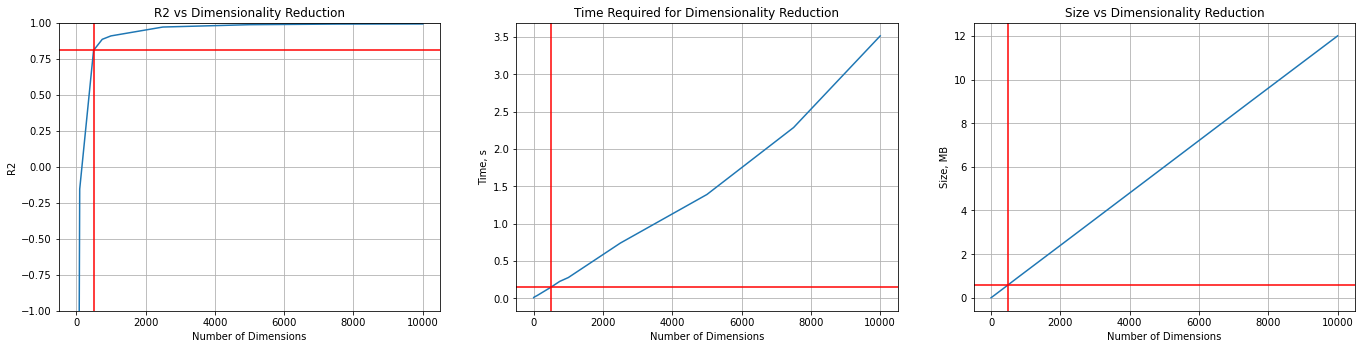

In [42]:
metric = 'euclidean' # choose type of distance metric (random projection uses euclidean to preserve pairwise distances)
accepted_r2 = 0.80   # desired error after dimensional reduction
n_samples, n_features = data.shape

print(f"Embedding {n_samples} samples with dim {n_features} using various random projections")
#n_components_range = np.linspace(1, data.shape[1], 5, dtype=int) # generating range of m dimensions to project to
n_components_range = np.array([1, 10, 100, 500, 750, 1_000, 2_500, 5_000, 7_500, 10_000]) # for personal preferences for m

dists = pairwise_distances(data, metric= metric).ravel()

dt = np.zeros(len(n_components_range))  # initializing array to store runtimes
r2 = np.zeros(len(n_components_range))  # initializing array to store r2
size= np.zeros(len(n_components_range)) # initializing array to store size of matrix  
nonzero = dists != 0
dists = dists[nonzero] # select only non-identical samples pairs

i = 0
for n_components in n_components_range:
    t0 = time()
    rp = random_projection.SparseRandomProjection(n_components=n_components, random_state=rand_seed) #initializing model
    projected_data = rp.fit_transform(data)                                                      #fitting model
    projected_dists = pairwise_distances(projected_data, metric=metric).ravel()[nonzero]         #calculating pairwise distance

    dt[i]   = time() - t0    #initializing array to store time to finish a run
    r2[i]   = r2_score(dists, projected_dists) # calculating the R2 of the model
    
    if hasattr(rp, "components_"):  # calculating size of matirx
        n_bytes = rp.components_.data.nbytes
        x= n_bytes
        n_bytes += rp.components_.indices.nbytes    
    size[i] = n_bytes
    
    print(f"{i+1}) " 
          f"Projected {n_samples} samples from {n_features} to {n_components} in "
          f"{time() - t0:0.3f}s" 
          f" with an R2 of {r2[i]:0.4f}"
          f" at a size of {size[i]/ 1e6:0.3f} MB")    
    i = i+1
    
sens_plotter(n_components_range, r2, dt, size/ 1e6, accepted_r2)

### Results

We notice that the plots show that $R^2$ platues and the increasing the number of dimensions is not worth the increase in memory and run-time for slight increase in accuracy. 

The block below automatically picks the optimum number of dimensions of the space to project into based on the input of the user of acceptable error in the previous plot. This is done to reduce the computational complexity even further by using the lowest number of dimesnions that achieves the desired $R^2$. if no case was able to reach the desired $R^2$, the algorithim will pick the space which has the minimum error from the sensitivity above.

The projection is then shown as a crossplot of original pairwise distance Vs. projected pairwise distance as a heat map indicating data density. The output also shows the distribution of the distances ($\frac{projected}{original}$) in a historgram along with the average and standard deviation of the distribution. 

Embedding 300 samples from 10000 dimensions space to 1000 space
r2 score: 0.9089 
Mean distances ratio: 0.99 (STDEV 0.14)


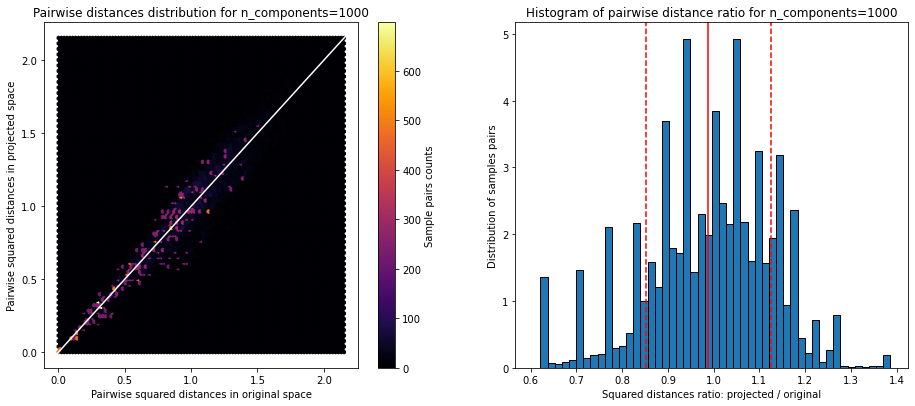

In [57]:
accepted_r2 = 0.9  # if you would like to change R2

if max(r2) >= accepted_r2:          # checking if maximum R2 calculated matches input of minimum R2
    number_components = n_components_range[min(np.where(r2 >= accepted_r2)[0])]
else:
    number_components= n_components_range[-1]    

dists = pairwise_distances(data, metric= metric).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

t0 = time()
rp = random_projection.SparseRandomProjection(n_components= number_components, random_state=rand_seed)
projected_data = rp.fit_transform(data)
projected_dists = pairwise_distances(projected_data, metric=metric).ravel()[nonzero]

print(f"Embedding {n_samples} samples from {n_features} dimensions space to {number_components} space")

r2_2 = r2_score(dists, projected_dists)
print(f"r2 score: {r2_2:0.4f} ")

pairwise_plotter(projected_dists, dists, number_components)